In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind


In [376]:
# Load the dataset
df = pd.read_csv('London_Listings.csv')

# Original shape
print('Original Shape:', df.shape)

# First 5 rows
df.head()

Original Shape: (66679, 31)


,id,name,description,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,amenities,price,minimum_nights,maximum_nights,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,calculated_host_listings_count
0,2.763150e+07,1,NaN,35877912,Alex,15/06/2015,NaN,NaN,f,1.0,...,"[""Kitchen"", ""Refrigerator"", ""Microwave"", ""Free...",$200.00,1,1125,14/06/2024,0,NaN,NaN,NaN,1
1,1.100000e+18,1,Get comfortable and enjoy plenty of extra room...,564055882,Lili-Ann,26/02/2024,NaN,NaN,f,1.0,...,[],$675.00,1,365,15/06/2024,0,NaN,NaN,NaN,1
2,1.170000e+18,117,Keep it simple at this peaceful and centrally-...,528033284,Shujauddin,26/07/2023,86%,50%,f,2.0,...,"[""Washer"", ""Wifi"", ""Kitchen""]",$95.00,1,365,16/06/2024,0,NaN,NaN,NaN,2
3,8.730000e+17,- Bright Central London Apartment -,My apartment has everything you possibly need ...,99268099,Alex,11/10/2016,98%,93%,t,5.0,...,"[""Microwave"", ""Hot water kettle"", ""Body soap"",...",$166.00,7,365,16/06/2024,24,24/04/2023,02/05/2024,4.83,1
4,4.672403e+07,""" Bright & Cosy Loft apartment """,Lovely and cosy arctic space with a separate d...,359199241,Karol,29/07/2020,100%,95%,t,1.0,...,"[""Cleaning products"", ""Cooking basics"", ""First...",$105.00,2,60,14/06/2024,46,20/08/2021,02/06/2024,4.89,1


In [377]:
# Check types before categorising
print(df.dtypes)

id                                float64
name                               object
description                        object
host_id                             int64
host_name                          object
host_since                         object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_listings_count               float64
host_total_listings_count         float64
neighbourhood                      object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms                         float64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                    

In [378]:
# Organise the coluns in categorical and numerical types
categorical_var = df.select_dtypes(include=['object']).columns.tolist()
numerical_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Variables:", categorical_var)
print("Numerical Variables:", numerical_var)

Categorical Variables: ['name', 'description', 'host_name', 'host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'calendar_last_scraped', 'first_review', 'last_review']
Numerical Variables: ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count']


In [379]:
# Fix the price column by removing $ sign and commas.
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Create a copy of the untouched dataset so we can compare to the data cleaning later.
df_first = df.copy()

# Remove listings with zero or negative prices
df = df[df['price'] > 0]
print(df['price'].describe())

# Drop rows where 'price' is NaN since it is a target variable. (Important one)
df.dropna(subset=['price'], inplace=True) # 61418
print("Shape after removing empty `price` rows:", df.shape)

# 3 properties of 80000.00, 1 propert of 1.00

count    61417.000000
mean       209.990621
std        961.458327
min          1.000000
25%         78.000000
50%        138.000000
75%        227.000000
max      80000.000000
Name: price, dtype: float64
Shape after removing empty `price` rows: (61417, 31)


In [380]:
# Categorical variables, remove empty strings or lists and replace with Nan.
for col in categorical_var:
    df[col] = df[col].replace(['', '[]'], np.nan)
    
missing_col_val = df.isnull().sum()
print('Missing column values:\n', missing_col_val[missing_col_val > 0])

Missing column values:
 description                   1870
host_name                        1
host_since                       1
host_response_rate            6615
host_acceptance_rate          4365
host_is_superhost              370
host_listings_count              1
host_total_listings_count        1
bathrooms                       69
bathrooms_text                 100
bedrooms                       101
beds                           140
amenities                      132
first_review                 14736
last_review                  14736
review_scores_rating         14736
dtype: int64


In [381]:
# Drop unnecessary columns, as they are either replaced or are useless in the model building.
drop_columns = ['host_name', 'calendar_last_scraped', 'bathrooms_text', 'latitude', 'longitude', 'first_review', 'last_review']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Updated shape
print("Shape after dropping unnecessary columns:", df.shape)

Shape after dropping unnecessary columns: (61417, 24)


In [382]:
# Fill missing values with median as it's the safest and least aggresive approach of thinning our dataset size
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)

# Updated shape
print('Shape after dropping duplicates and NaN rows:', df.shape)

Shape after dropping duplicates and NaN rows: (61417, 24)


In [383]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 51


In [384]:
# Drop duplicate rows since the number of duplicates is low compared to our dataset size
df.drop_duplicates(inplace=True)
# Check the new shape
print("Shape after dropping duplicates:", df.shape)

Shape after dropping duplicates: (61366, 24)


In [385]:
# Count rows where number_of_reviews is 0 and review_scores_rating is NaN
zero_reviews_missing_rating = df[(df['number_of_reviews'] == 0) & (df['review_scores_rating'].isnull())]

print(f"Listings with 0 reviews and missing rating: {zero_reviews_missing_rating.shape[0]}")
print(f"Total missing review_scores_rating: {df['review_scores_rating'].isnull().sum()}")


Listings with 0 reviews and missing rating: 14686
Total missing review_scores_rating: 14686


In [386]:
# Fill missing review scores with 0 (indicating that there have no reviews)
df.loc[df['number_of_reviews'] == 0, 'review_scores_rating'] = 0

# Check if missing values remain
print("Missing values after fixing review_scores_rating:", df['review_scores_rating'].isnull().sum())

Missing values after fixing review_scores_rating: 0


In [387]:
# Fill missing columns
df['amenities'].fillna("Unknown", inplace=True)
df['description'].fillna("No description", inplace=True)

# Convert response & acceptance rate to numeric by removing % and diving by 100
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float) / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

# Fill missing values with median
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median(), inplace=True)

# Convert 'host_is_superhost' to binary (t → 1, f → 0)
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
df['host_is_superhost'].fillna(0, inplace=True)  # Assuming that missing → not superhost

# Check if missing values remain
print("Missing values after handling host columns:\n", df.isnull().sum()[df.isnull().sum() > 0])

Missing values after handling host columns:
 host_since                   1
host_listings_count          1
host_total_listings_count    1
dtype: int64


In [388]:
# Drop rows where values of the subset are missing, since it's only 3 in the dataset this is an insignificant loss. Not likely to scew the data.
df.dropna(subset=['host_since', 'host_listings_count', 'host_total_listings_count'], inplace=True)
print("Missing values after dropping specific rows:\n", df.isnull().sum()[df.isnull().sum() > 0])


Missing values after dropping specific rows:
 Series([], dtype: int64)


In [389]:
# Let's check the shape of the dataset after all this cleaning.
print("Shape after cleaning:", df.shape)

#df.to_csv('datasetAfterCleaning.csv', index=False)

Shape after cleaning: (61365, 24)


In [390]:
# Keep a copy of categorical columns for visualization
df['neighbourhood_original'] = df['neighbourhood']
df['property_type_original'] = df['property_type']
df['room_type_original'] = df['room_type']

# One-Hot Encode categorical variables (new columns)
df = pd.get_dummies(df, columns=['neighbourhood', 'property_type', 'room_type'], drop_first=True)

# Check updated shape
print("Shape after encoding with preserved original columns:", df.shape)
print(df.columns)

Shape after encoding with preserved original columns: (61365, 143)
Index(['id', 'name', 'description', 'host_id', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       ...
       'property_type_Shared room in vacation home',
       'property_type_Shared room in villa', 'property_type_Shepherd’s hut',
       'property_type_Shipping container', 'property_type_Tent',
       'property_type_Tiny home', 'property_type_Tower',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object', length=143)


In [391]:
# df.to_csv('df_post_encode_with_prop_type.csv', index=False)

df['price'] = winsorize(df['price'], limits=[0.01, 0.01])
df['accommodates'] = winsorize(df['accommodates'], limits=[0.01, 0.01])
df['bedrooms'] = winsorize(df['bedrooms'], limits=[0.01, 0.01])
df['beds'] = winsorize(df['beds'], limits=[0.01, 0.01])
df['bathrooms'] = winsorize(df['bathrooms'], limits=[0.01, 0.01])


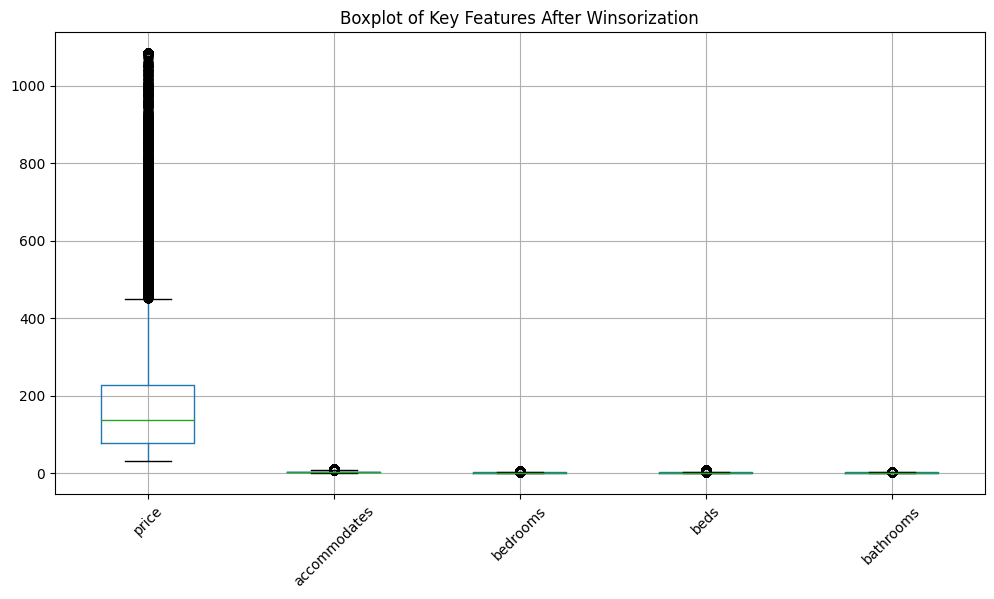

In [392]:
# Define columns to check
outlier_cols = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms']

# Plot boxplots after Winsorization
plt.figure(figsize=(12, 6))
df[outlier_cols].boxplot()
plt.title("Boxplot of Key Features After Winsorization")
plt.xticks(rotation=45)
plt.show()

In [393]:
df['log_price'] = np.log(df['price'])
df[['price', 'log_price']].describe()

,price,log_price
count,61365.000000,61365.000000
mean,188.032413,4.925350
std,176.302619,0.769221
min,30.000000,3.401197
25%,78.000000,4.356709
50%,138.000000,4.927254
75%,227.000000,5.424950
max,1084.000000,6.988413


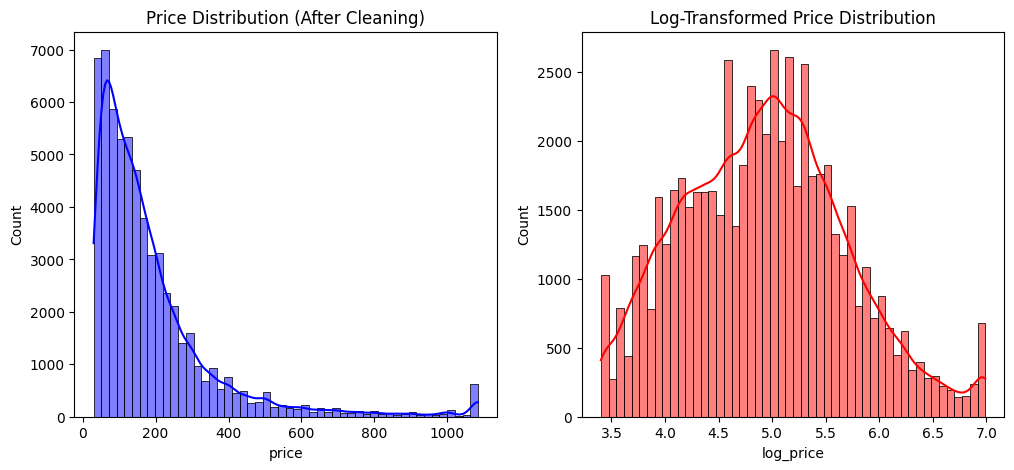

In [394]:
plt.figure(figsize=(12, 5))

# Original price distribution
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title("Price Distribution (After Cleaning)")

# Log-transformed price distribution
plt.subplot(1, 2, 2)
sns.histplot(df['log_price'], bins=50, kde=True, color='red')
plt.title("Log-Transformed Price Distribution")

plt.show()

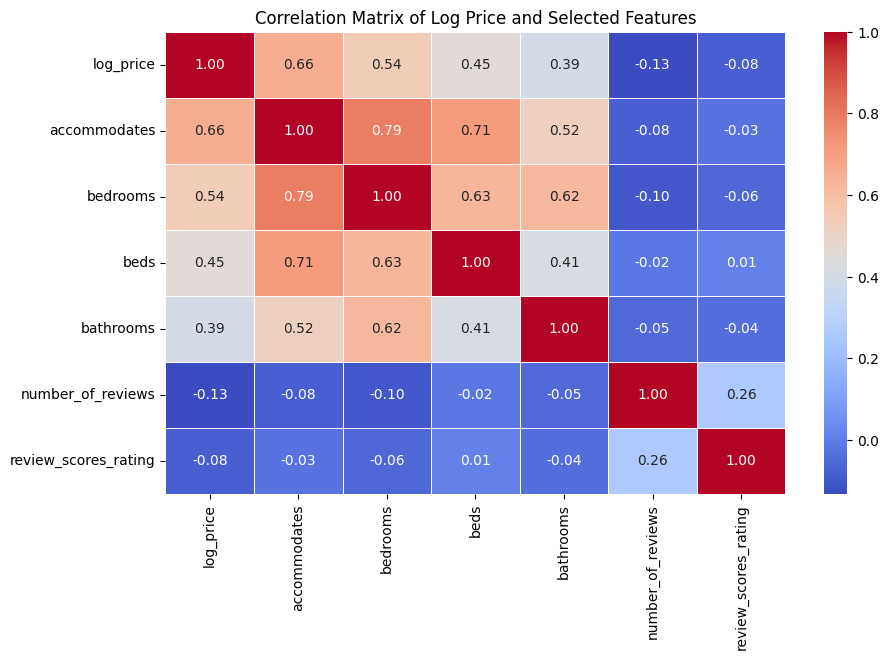

In [395]:
# Compute correlation matrix including log_price
correlation_features = ['log_price', 'accommodates', 'bedrooms', 'beds', 
                        'bathrooms', 'number_of_reviews', 'review_scores_rating']

correlation_matrix = df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Log Price and Selected Features')
plt.show()

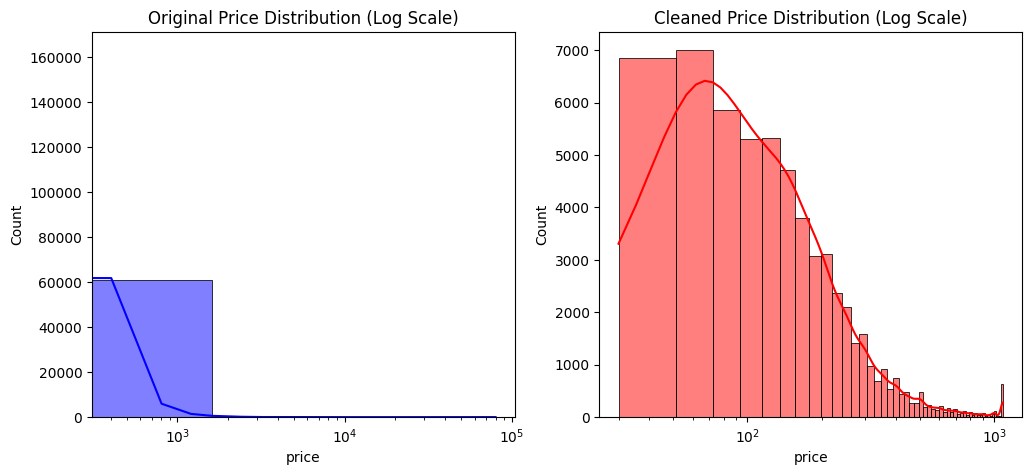

In [396]:
plt.figure(figsize=(12, 5))

# Original price distribution (log scale to fix overlap)
plt.subplot(1, 2, 1)
sns.histplot(df_first['price'], bins=50, kde=True, color='blue')
plt.xscale('log')  # Apply log scale to x-axis
plt.title("Original Price Distribution (Log Scale)")

# Cleaned price distribution
plt.subplot(1, 2, 2)
sns.histplot(df['price'], bins=50, kde=True, color='red')
plt.xscale('log')
plt.title("Cleaned Price Distribution (Log Scale)")

plt.show()

In [398]:
numerical_features = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'review_scores_rating']

# Create a copy before normalization
df_original = df.copy()

# Apply StandardScaler
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Check transformation
print(df[numerical_features].describe())

       accommodates      bedrooms          beds     bathrooms  \
count  6.136500e+04  6.136500e+04  6.136500e+04  6.136500e+04   
mean   7.040006e-17 -9.911588e-17  1.537686e-16  1.574738e-17   
std    1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00   
min   -1.181587e+00 -1.621351e+00 -1.170253e+00 -1.379071e+00   
25%   -6.856458e-01 -5.563078e-01 -4.499593e-01 -5.735629e-01   
50%   -1.897046e-01 -5.563078e-01 -4.499593e-01 -5.735629e-01   
75%    3.062365e-01  5.087353e-01  2.703348e-01  2.319454e-01   
max    3.281883e+00  3.703865e+00  3.871805e+00  4.259487e+00   

       number_of_reviews  review_scores_rating  
count       6.136500e+04          6.136500e+04  
mean        2.593687e-17         -1.551580e-16  
std         1.000008e+00          1.000008e+00  
min        -4.431653e-01         -1.746612e+00  
25%        -4.242176e-01         -2.772588e-01  
50%        -3.294789e-01          5.504771e-01  
75%        -7.367583e-03          6.778211e-01  
max         3.135112e+

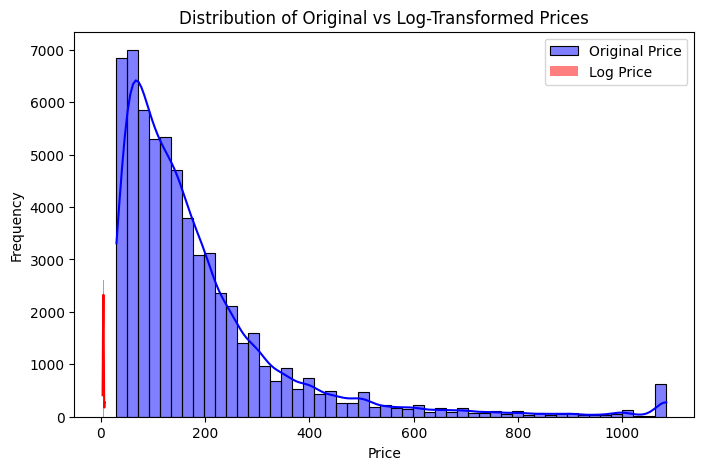

In [ ]:
# Visualization: Log Price Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_original['price'], bins=50, kde=True, color='blue', label='Original Price')
sns.histplot(df_original['log_price'], bins=50, kde=True, color='red', label='Log Price')
plt.legend()
plt.title('Distribution of Original vs Log-Transformed Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

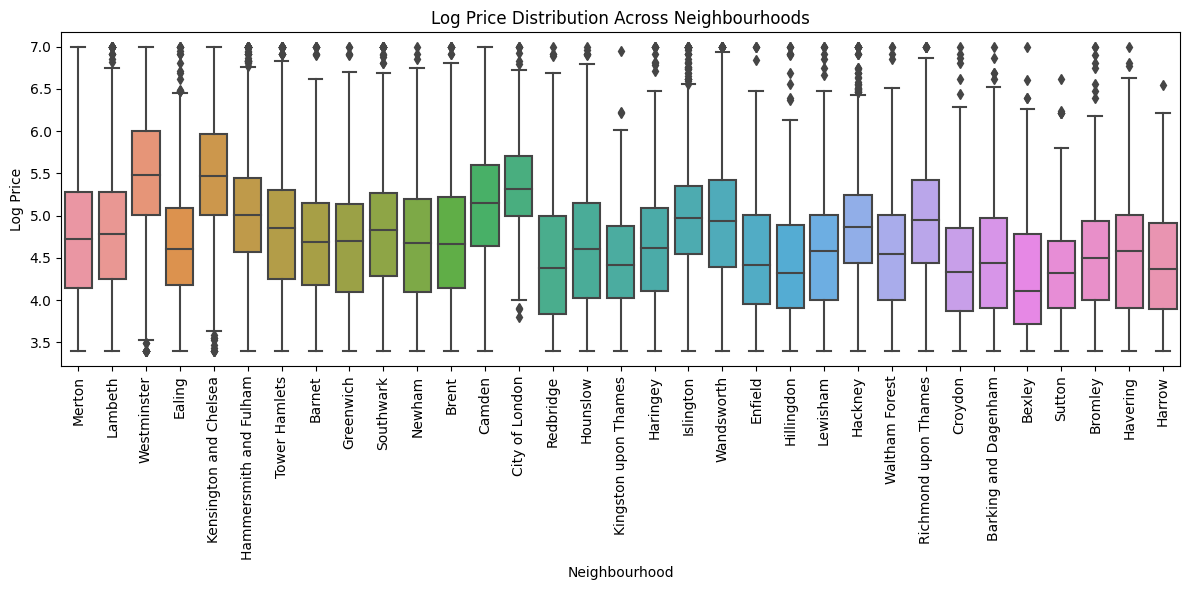

In [400]:
# Visualization: Price Across Neighborhoods
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='neighbourhood_original', y='log_price')
plt.xticks(rotation=90)
plt.title('Log Price Distribution Across Neighbourhoods')
plt.xlabel('Neighbourhood')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

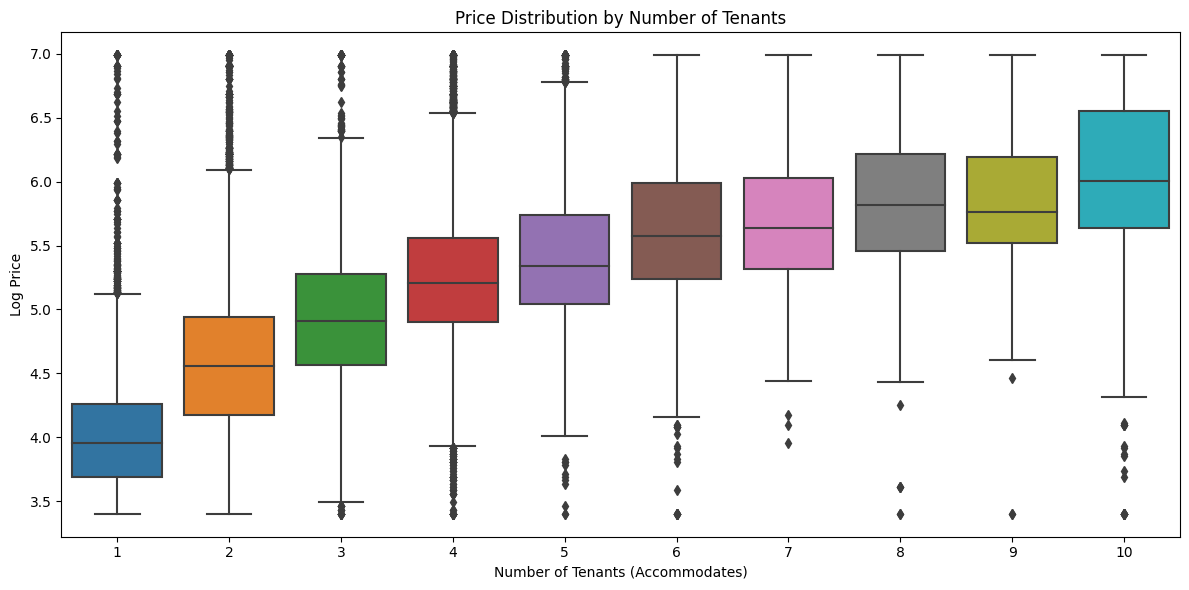

In [402]:
# Visualization: Price by Number of Tenants (Accommodates)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_original, x='accommodates', y='log_price')
plt.title('Price Distribution by Number of Tenants')
plt.xlabel('Number of Tenants (Accommodates)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

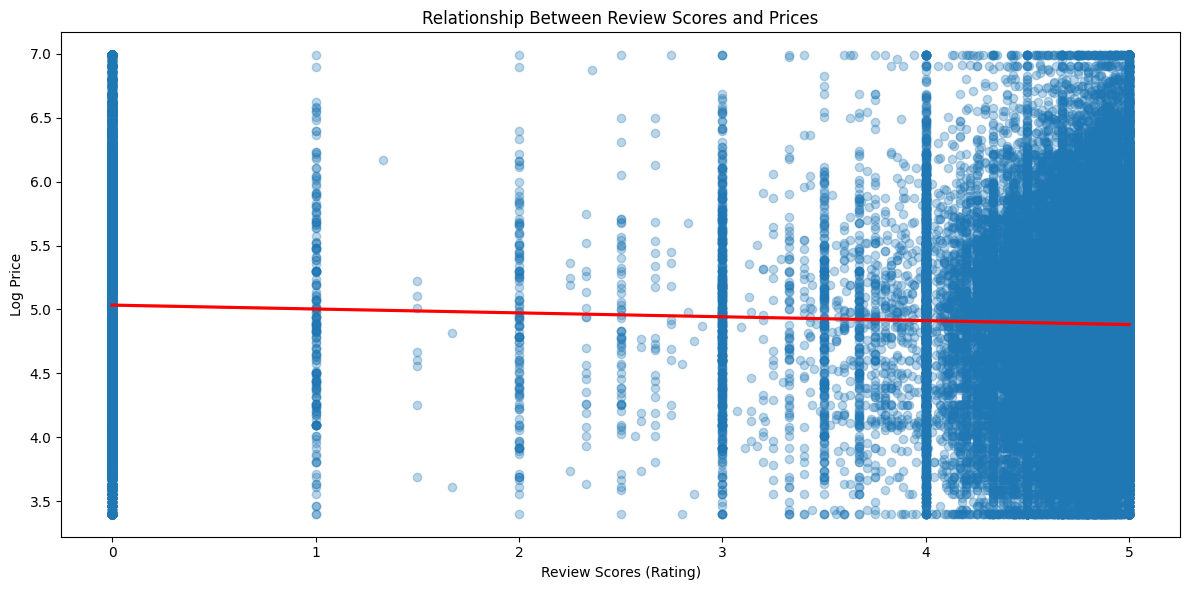

In [403]:
# Visualization: Relationship Between Review Scores and Prices
plt.figure(figsize=(12, 6))
sns.regplot(
    data=df_original,
    x='review_scores_rating',
    y='log_price',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Review Scores and Prices')
plt.xlabel('Review Scores (Rating)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()